In [1]:
from __future__ import print_function
%matplotlib inline
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


###############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))
eigenfaces = pca.components_.reshape((n_components, h, w))
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
2017-02-12 21:14:26,319 Loading LFW people faces from /Users/salemameen/scikit_learn_data/lfw_home
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/deprecation.p

Automatically created module for IPython interactive environment
Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Extracting the top 150 eigenfaces from 966 faces
done in 0.165s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.024s


In [2]:
###############################################################################
# Qualitative evaluation of the predictions using matplotlib
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

## KNN classifier

In [3]:
from sklearn.neighbors import KNeighborsClassifier
###############################################################################
# Train a knn classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid =  {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14]}
clf = GridSearchCV(KNeighborsClassifier(algorithm='auto'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 1.761s
Best estimator found by grid search:
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')


Predicting people's names on the test set
done in 0.075s
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.38      0.45        13
     Colin Powell       0.89      0.57      0.69        60
  Donald Rumsfeld       0.48      0.44      0.46        27
    George W Bush       0.75      0.90      0.82       146
Gerhard Schroeder       0.64      0.36      0.46        25
      Hugo Chavez       0.50      0.73      0.59        15
       Tony Blair       0.55      0.61      0.58        36

      avg / total       0.71      0.70      0.69       322

[[  5   1   2   2   0   2   1]
 [  2  34   3  12   2   2   5]
 [  1   0  12  10   1   1   2]
 [  0   1   4 131   1   5   4]
 [  1   0   2   6   9   1   6]
 [  0   2   1   1   0  11   0]
 [  0   0   1  12   1   0  22]]


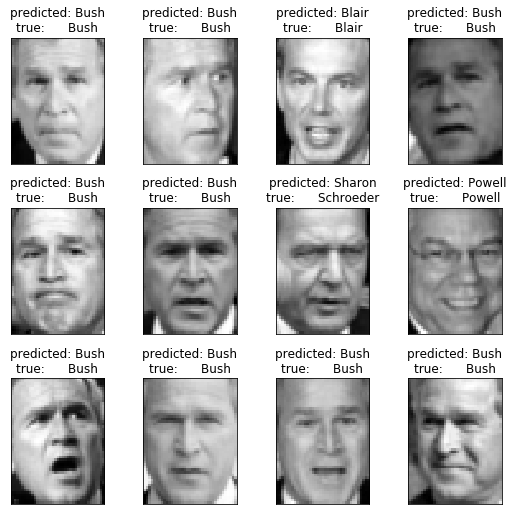

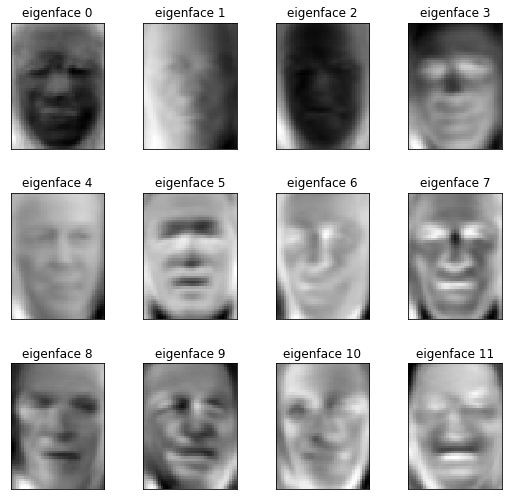

In [4]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
y_pred_neigh = y_pred
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## SVM classifier



In [5]:
###############################################################################
# Train a SVM classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 13.860s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Predicting people's names on the test set
done in 0.038s
                   precision    recall  f1-score   support

     Ariel Sharon       0.69      0.69      0.69        13
     Colin Powell       0.76      0.90      0.82        60
  Donald Rumsfeld       0.72      0.78      0.75        27
    George W Bush       0.89      0.90      0.89       146
Gerhard Schroeder       0.86      0.76      0.81        25
      Hugo Chavez       0.89      0.53      0.67        15
       Tony Blair       0.90      0.75      0.82        36

      avg / total       0.84      0.84      0.83       322

[[  9   0   2   2   0   0   0]
 [  1  54   2   2   0   1   0]
 [  3   0  21   3   0   0   0]
 [  0  11   2 131   1   0   1]
 [  0   2   0   4  19   0   0]
 [  0   1   0   2   2   8   2]
 [  0   3   2   4   0   0  27]]


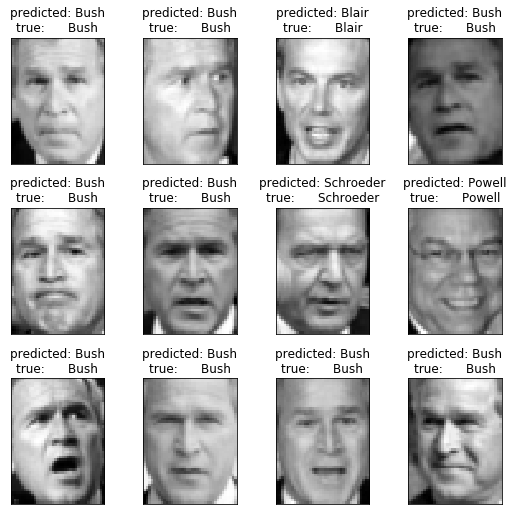

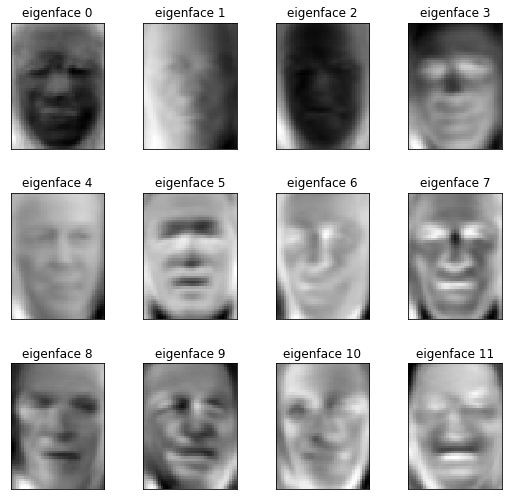

In [6]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
y_pred_svm = y_pred
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## Decsion Tree classifier



In [7]:
from sklearn.tree import DecisionTreeClassifier
###############################################################################
# Train a DT classification model
print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'criterion':('gini', 'entropy'),
              'min_samples_split': [2, 3, 4],
              'min_samples_leaf': [2, 3, 4]}

clf = GridSearchCV(DecisionTreeClassifier(), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 6.071s
Best estimator found by grid search:
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


Predicting people's names on the test set
done in 0.001s
                   precision    recall  f1-score   support

     Ariel Sharon       0.07      0.15      0.10        13
     Colin Powell       0.41      0.40      0.40        60
  Donald Rumsfeld       0.21      0.26      0.23        27
    George W Bush       0.62      0.53      0.57       146
Gerhard Schroeder       0.09      0.08      0.08        25
      Hugo Chavez       0.07      0.07      0.07        15
       Tony Blair       0.28      0.31      0.29        36

      avg / total       0.42      0.39      0.40       322

[[ 2  1  3  5  1  0  1]
 [ 9 24  5 15  1  2  4]
 [ 2  3  7 12  3  0  0]
 [ 7 19 16 78  9  3 14]
 [ 1  1  0  9  2  5  7]
 [ 2  5  0  1  4  1  2]
 [ 4  6  3  6  3  3 11]]


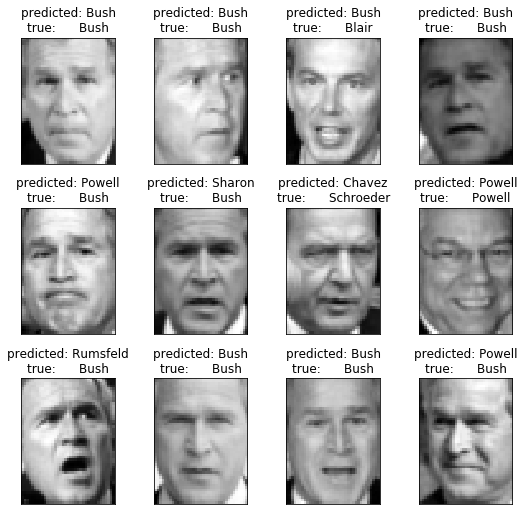

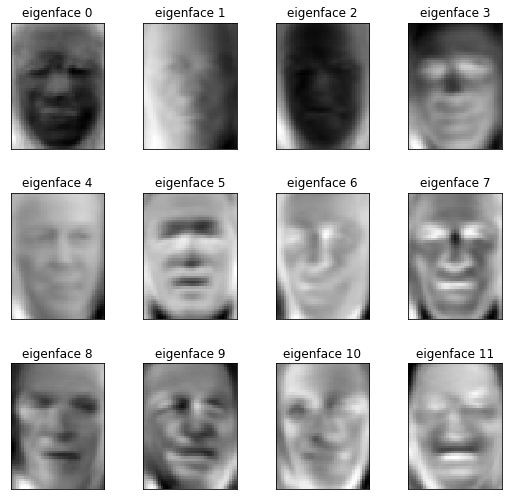

In [8]:
###############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
y_pred_dt_IG = y_pred
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## Neural Networks classifier

In [9]:
import seaborn as sns
import time 
import numpy as np
from sklearn.cross_validation import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2

from keras.utils import np_utils

labelsTrain = np_utils.to_categorical(y_train)
labelsTest = np_utils.to_categorical(y_test) 

model = Sequential()
model.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(7, activation="softmax"))

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
# Actual modelling
start_time = time.time()
model.fit(X_train_pca, labelsTrain, verbose=0, batch_size=100, nb_epoch=100)
print("The time for training NN is  %s seconds " % (time.time() - start_time))
score, accuracy = model.evaluate(X_test_pca, labelsTest, batch_size=100, verbose=0)
print("Test fraction correct (NN-Score) = {:.2f}".format(score))
print("Test fraction correct (NN-Accuracy) = {:.2f}".format(accuracy))

Using Theano backend.


The time for training NN is  24.501391887664795 seconds 
Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85


Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.064s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.90      0.95      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.85      0.85       322

[[  7   2   2   2   0   0   0]
 [  1  53   2   3   0   1   0]
 [  0   2  21   3   0   1   0]
 [  0   5   2 138   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


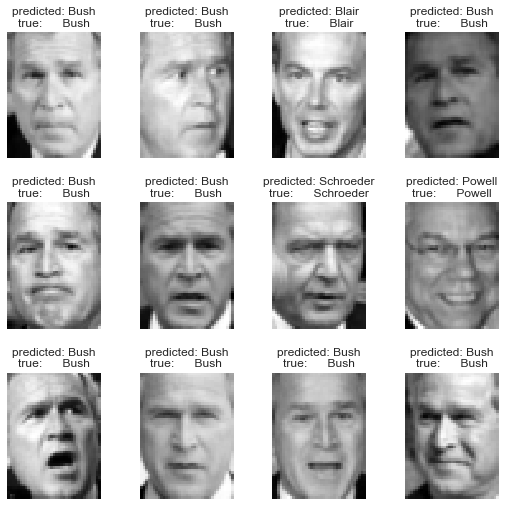

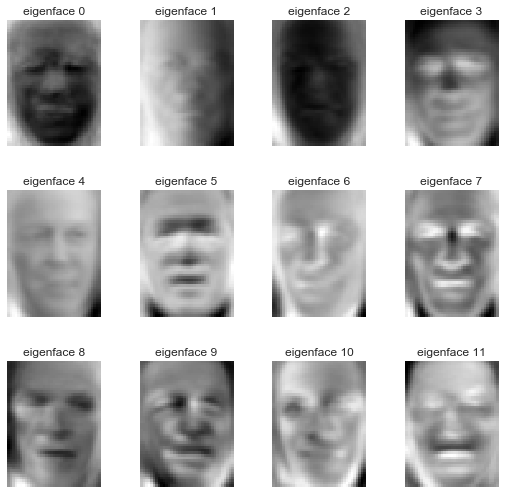

In [10]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model.predict_classes(X_test_pca)
y_pred_NN = y_pred
print("done in %0.3fs" % (time() - t0))

print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

In [11]:
import sys
path = './face/'
sys.path.append("./face")
model.save_weights('faceModelbest.hdf5',overwrite=True)

# Multi Armed Bandit

In [12]:
#execfile("/Users/salemameen/Desktop/banditsbook/python_face/core.py")
exec(open("core.py").read())  # pyhton 3x

## Run UCB1 pruning Algorithm


Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.3566720485687256 seconds 
Finsh playing start pruining:
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.8

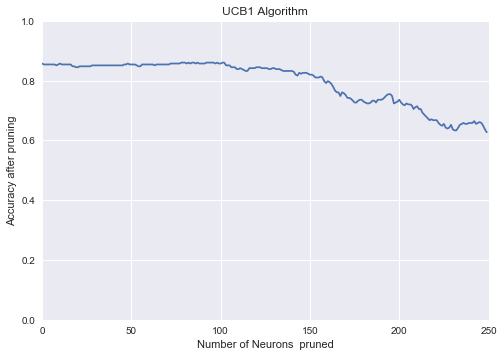

In [13]:
algo = UCB1([], [])
Alg_name = 'UCB1 Algorithm'
path = './UCB1/'
sys.path.append("./UCB1")
exec(open("mnist_cnnFORTESTING.py").read())

## Run epsilon greedy pruning Algorithm

Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.1430869102478027 seconds 
Finsh playing start pruining:
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.8

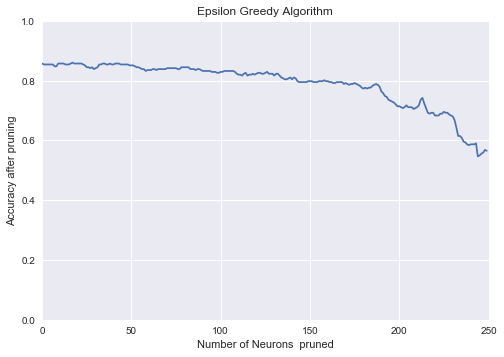

In [14]:
epsilon = 0.9 # epsilon = (0,1)
algo = EpsilonGreedy(epsilon, [], [])
Alg_name = 'Epsilon Greedy Algorithm'
path = './EpsilonGreedy/'
sys.path.append("./AnnealingEpsilonGreedy")
exec(open("mnist_cnnFORTESTING.py").read())

## Run decay epsilon greedy pruning Algorithm

Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.2091758251190186 seconds 
Finsh playing start pruining:
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.86
Test after pruning= 0.8

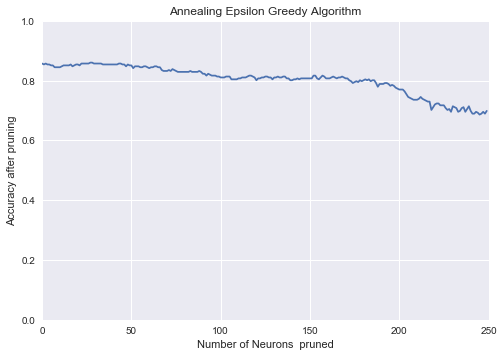

In [15]:
algo = AnnealingEpsilonGreedy([], [])
Alg_name = 'Annealing Epsilon Greedy Algorithm'
path = './AnnealingEpsilonGreedy/'
sys.path.append("./AnnealingEpsilonGreedy")
exec(open("mnist_cnnFORTESTING.py").read())

## Run softmax pruning Algorithm

Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.2864670753479004 seconds 
Finsh playing start pruining:
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.8

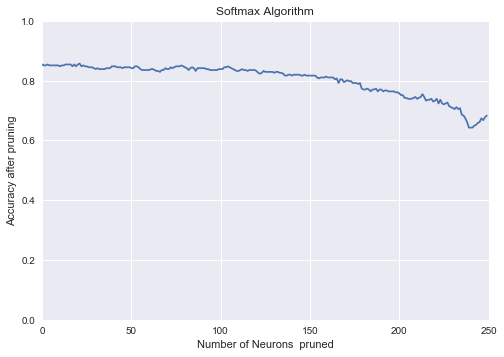

In [16]:
temperature = 0.9
algo = Softmax(temperature, [], [])
Alg_name = 'Softmax Algorithm'
path = './Softmax/'
sys.path.append("./Softmax")
exec(open("mnist_cnnFORTESTING.py").read())

## Run Decay softmax pruning Algorithm

Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.4275081157684326 seconds 
Finsh playing start pruining:
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.8

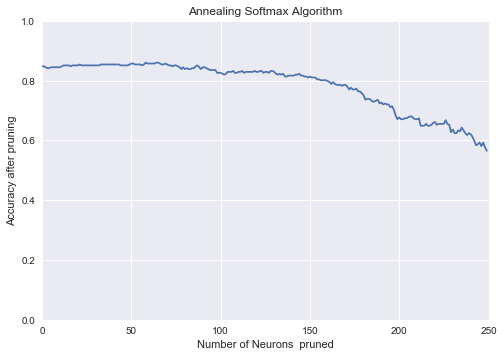

In [17]:
algo = AnnealingSoftmax([], [])
Alg_name = 'Annealing Softmax Algorithm'
path = './AnnealingSoftmax/'
sys.path.append("./AnnealingSoftmax")
exec(open("mnist_cnnFORTESTING.py").read())

## Run thompson sampling pruning Algorithm

Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.907480001449585 seconds 
Finsh playing start pruining:
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.86
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85

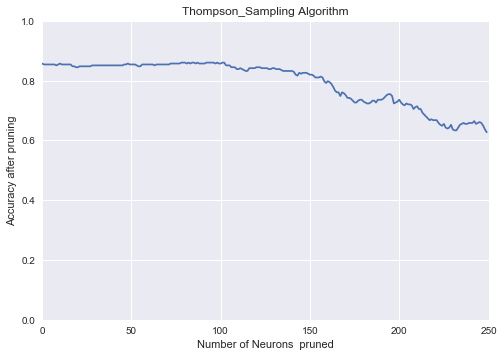

In [18]:
algo = Thompson_Sampling([], [])
Alg_name = 'Thompson_Sampling Algorithm'
path = './Thompson_Sampling/'
sys.path.append("./Thompson_Sampling")
exec(open("mnist_cnnFORTESTING.py").read())

## Run Hedge pruning Algorithm

Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.3939929008483887 seconds 
Finsh playing start pruining:
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.8

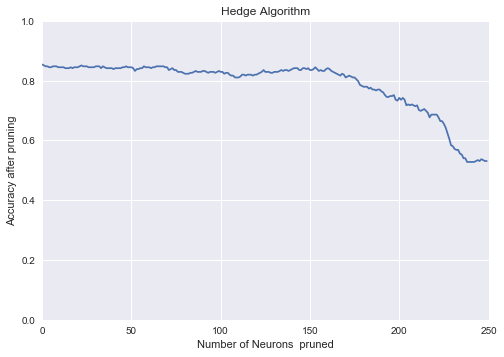

In [19]:
eta = 0.9  # eta in [.5, .8, .9, 1, 2]
algo = Hedge(eta, [], []) 
Alg_name = 'Hedge Algorithm'
path = './Hedge/'
sys.path.append("./Hedge")
exec(open("mnist_cnnFORTESTING.py").read())

## Run EXP3 pruning Algorithm

Test fraction correct (NN-Score) = 0.68
Test fraction correct (NN-Accuracy) = 0.85
The time for running this method is 2.4257519245147705 seconds 
Finsh playing start pruining:
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.84
Test after pruning= 0.85
Test after pruning= 0.85
Test after pruning= 0.8

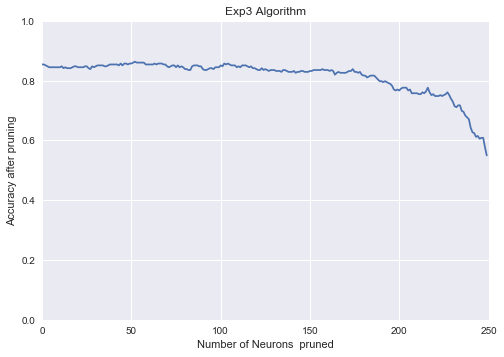

In [20]:
exp3_gamma = 0.2 #exp3_gamma in [0.1, 0.2, 0.3, 0.4, 0.5]
algo = Exp3(exp3_gamma, [])
Alg_name = 'Exp3 Algorithm'
path = './Exp3/'
sys.path.append("./EpsilonGreedy")
exec(open("mnist_cnnFORTESTING.py").read())

# Compare the accuracy of the models

In [21]:
ucb1 = np.load('./UCB1/AccuracyAftrerPrune.npy')
EpsilonGreedy = np.load('./EpsilonGreedy/AccuracyAftrerPrune.npy')
AnnealingEpsilonGreedy = np.load('./AnnealingEpsilonGreedy/AccuracyAftrerPrune.npy')
Softmax = np.load('./Softmax/AccuracyAftrerPrune.npy')
AnnealingSoftmax = np.load('./AnnealingSoftmax/AccuracyAftrerPrune.npy')
Exp3 = np.load('./Exp3/AccuracyAftrerPrune.npy')
Hedge = np.load('./Hedge/AccuracyAftrerPrune.npy')
ThompsonSampling = np.load('./Thompson_Sampling/AccuracyAftrerPrune.npy')
Accuracy = np.load('AccuracyBeforePruning.npy')

## Comparing All algorithms with the model before pruning

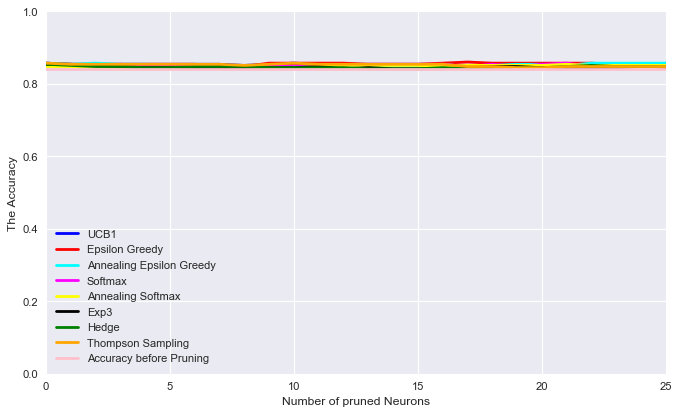

In [22]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(ucb1)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , ucb1 , color="blue", linewidth=2.5, linestyle="-", label="UCB1")
plt.plot(ind , EpsilonGreedy, color="red", linewidth=2.5, linestyle="-", label="Epsilon Greedy")
plt.plot(ind , AnnealingEpsilonGreedy, color="cyan", linewidth=2.5, linestyle="-", label="Annealing Epsilon Greedy")
plt.plot(ind , Softmax, color="magenta", linewidth=2.5, linestyle="-", label="Softmax")
plt.plot(ind , AnnealingSoftmax, color="yellow", linewidth=2.5, linestyle="-", label="Annealing Softmax")
plt.plot(ind , Exp3, color="black", linewidth=2.5, linestyle="-", label="Exp3")
plt.plot(ind , Hedge, color="green", linewidth=2.5, linestyle="-", label="Hedge")
plt.plot(ind , ThompsonSampling, color="orange", linewidth=2.5, linestyle="-", label="Thompson Sampling")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [23]:
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

############################################################################################################
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
output_notebook()
#############################################################################################
p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)


#p1.circle(ind, ucb1, legend="ucb1", color="orange")
p1.line(ind, ucb1, legend="ucb1", line_color="orange", line_width=2)

#p1.square(ind, EpsilonGreedy, legend="Epsilon Greedy", fill_color=None, line_color="red")
p1.line(ind, EpsilonGreedy, legend="Epsilon Greedy", line_color="red", line_width=2)

#p1.ellipse(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", height=0.01, width=0.01)
p1.line(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", line_width=2)

#p1.diamond(ind, Softmax, legend="Softmax", line_color="green")
p1.line(ind, Softmax, legend="Softmax", line_color="green", line_width=2)

#p1.arc(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", end_angle= 5, radius= 0.5, start_angle= 1)
p1.line(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", line_width=2)

#p1.oval(ind, Exp3, legend="Exp3", line_color="black", height=0.01, width=0.01)
p1.line(ind, Exp3, legend="Exp3", line_color="black", line_width=2)

#p1.arc(ind, Hedge, legend="Hedge", line_color="yellow")
#p1.triangle(ind, Hedge, legend="Hedge", line_color="yellow")
p1.line(ind, Hedge, legend="Hedge", line_color="yellow", line_width=2)


#p1.square_cross(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink")
p1.line(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink", line_width=2)


p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

Loading BokehJS ...

## UCB1

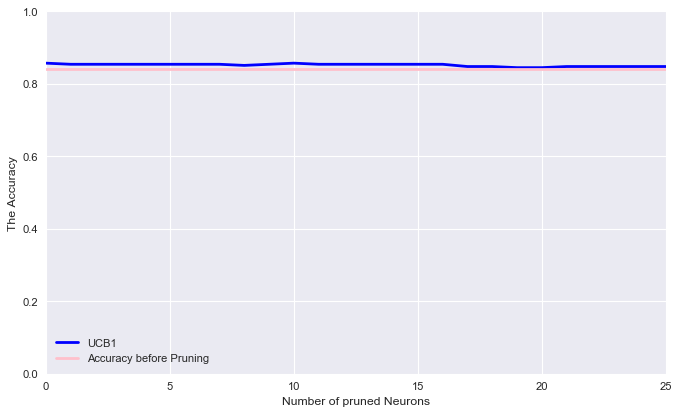

In [24]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(ucb1)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , ucb1 , color="blue", linewidth=2.5, linestyle="-", label="UCB1")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [25]:
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

############################################################################################################
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
output_notebook()
#############################################################################################
p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)


#p1.circle(ind, ucb1, legend="ucb1", color="orange")
p1.line(ind, ucb1, legend="ucb1", line_color="orange", line_width=2)
p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a brow

Loading BokehJS ...

## Epsilon greedy and Softmax

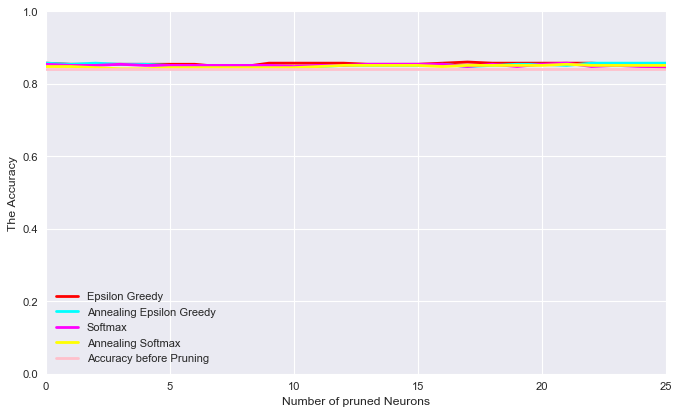

In [26]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(EpsilonGreedy)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , EpsilonGreedy, color="red", linewidth=2.5, linestyle="-", label="Epsilon Greedy")
plt.plot(ind , AnnealingEpsilonGreedy, color="cyan", linewidth=2.5, linestyle="-", label="Annealing Epsilon Greedy")
plt.plot(ind , Softmax, color="magenta", linewidth=2.5, linestyle="-", label="Softmax")
plt.plot(ind , AnnealingSoftmax, color="yellow", linewidth=2.5, linestyle="-", label="Annealing Softmax")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [27]:
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

############################################################################################################
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
output_notebook()
#############################################################################################
p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)


#p1.square(ind, EpsilonGreedy, legend="Epsilon Greedy", fill_color=None, line_color="red")
p1.line(ind, EpsilonGreedy, legend="Epsilon Greedy", line_color="red", line_width=2)

#p1.ellipse(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", height=0.01, width=0.01)
p1.line(ind, AnnealingEpsilonGreedy, legend="Annealing Epsilon Greedy", line_color="blue", line_width=2)

#p1.diamond(ind, Softmax, legend="Softmax", line_color="green")
p1.line(ind, Softmax, legend="Softmax", line_color="green", line_width=2)

#p1.arc(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", end_angle= 5, radius= 0.5, start_angle= 1)
p1.line(ind, AnnealingSoftmax, legend="Annealing Softmax", line_color="grey", line_width=2)

p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

Loading BokehJS ...

## Adversial Bandits Hedge and EXP3

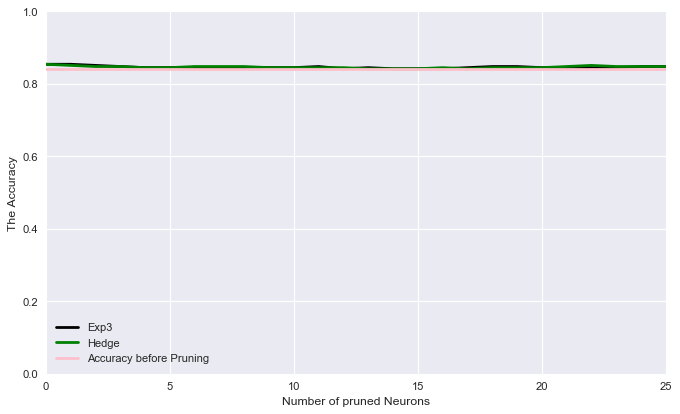

In [28]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(Exp3)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , Exp3, color="black", linewidth=2.5, linestyle="-", label="Exp3")
plt.plot(ind , Hedge, color="green", linewidth=2.5, linestyle="-", label="Hedge")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [29]:
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

############################################################################################################
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
output_notebook()
#############################################################################################
p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)

#p1.oval(ind, Exp3, legend="Exp3", line_color="black", height=0.01, width=0.01)
p1.line(ind, Exp3, legend="Exp3", line_color="black", line_width=2)

#p1.arc(ind, Hedge, legend="Hedge", line_color="yellow")
#p1.triangle(ind, Hedge, legend="Hedge", line_color="yellow")
p1.line(ind, Hedge, legend="Hedge", line_color="yellow", line_width=2)

p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

Loading BokehJS ...

## Thompson Sampling

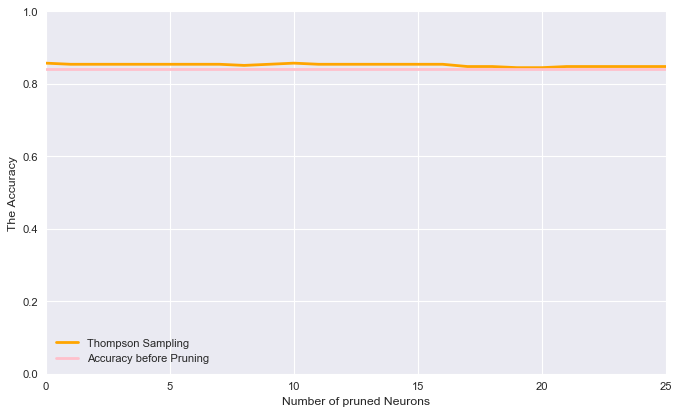

In [30]:
fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)
N = len(ThompsonSampling)
Acc = [Accuracy for col in range(N)]
## necessary variables
ind = np.arange(N)                # the x locations for the groups
plt.plot(ind , ThompsonSampling, color="orange", linewidth=2.5, linestyle="-", label="Thompson Sampling")
plt.plot(ind , Acc, color="pink", linewidth=2.5, linestyle="-", label="Accuracy before Pruning")
plt.legend(loc = 3)
plt.axis([0, 25, 0, 1])
plt.xlabel('Number of pruned Neurons')
plt.ylabel('The Accuracy')
plt.grid(True)
plt.show()

In [31]:
from bokeh.layouts import row, gridplot
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

############################################################################################################
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
output_notebook()
#############################################################################################
p1 = figure(title="The Performance over the number of neurons' pruned", tools=TOOLS)

#p1.square_cross(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink")
p1.line(ind, ThompsonSampling, legend="Thompson Sampling", line_color="pink", line_width=2)


p1.line(ind, Acc, legend="Accuracy", line_dash=(4, 4), line_color="orange", line_width=2)
#p1.square(ind, Hedge, legend="3*sin(x)", fill_color=None, line_color="brown")
p1.title.align = "center"


show(p1)
#show(gridplot(p1, p2, ncols=2, plot_width=400, plot_height=400))  # open a browser

Loading BokehJS ...

## UCB1 NN after pruning

In [32]:
# MAB_NN(4%REMOVED) MODEL1 10
model1 = Sequential()
model1.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(7, activation="softmax"))
model1.load_weights('./UCB1/spam5.hdf5')
model1.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.057s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.90      0.94      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.93      0.75      0.83        36

      avg / total       0.86      0.85      0.85       322

[[  8   2   2   1   0   0   0]
 [  1  53   2   3   0   1   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 137   0   1   1]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


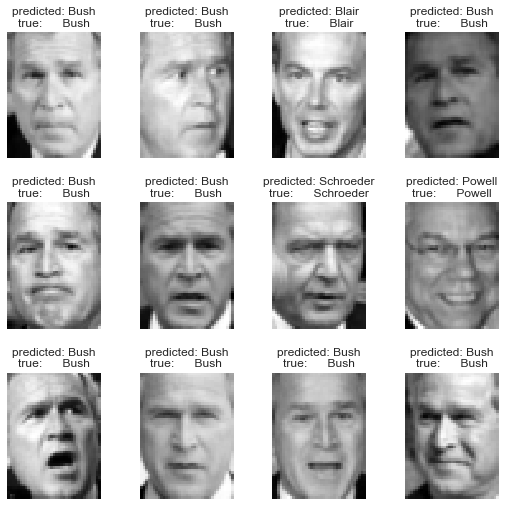

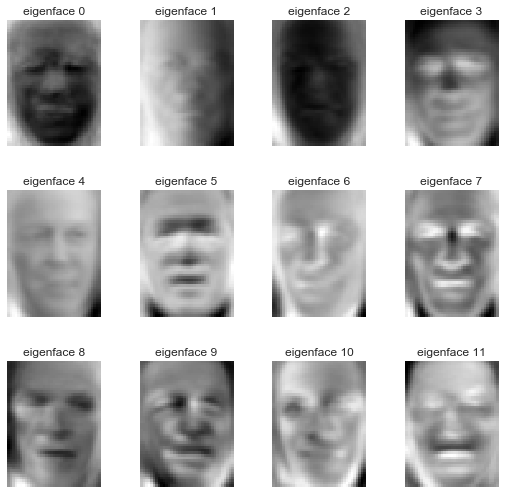

In [33]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model1.predict_classes(X_test_pca)
y_pred_NN1 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## NN after pruning 8.8%

In [34]:
# MAB_NN(8.8%REMOVED) MODEL1 22
model2 = Sequential()
model2.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model2.add(Dropout(0.5))
model2.add(Dense(7, activation="softmax"))
model2.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/UCB1/spam20.hdf5')
model2.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.063s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.77      0.85      0.81        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.88      0.94      0.91       146
Gerhard Schroeder       0.83      0.76      0.79        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.93      0.75      0.83        36

      avg / total       0.85      0.84      0.84       322

[[  8   2   2   1   0   0   0]
 [  1  51   2   4   0   2   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 137   0   1   1]
 [  0   2   0   4  19   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   4   2   0  27]]


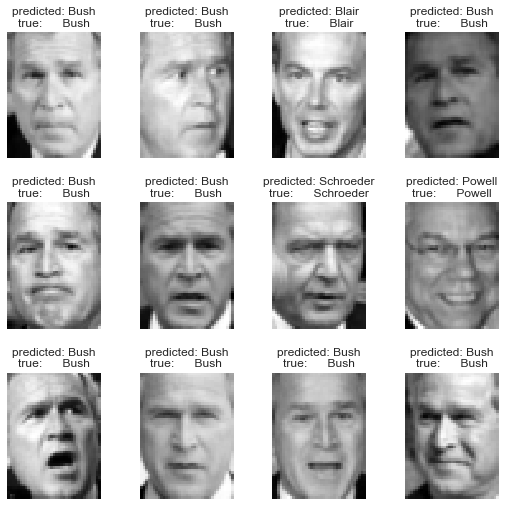

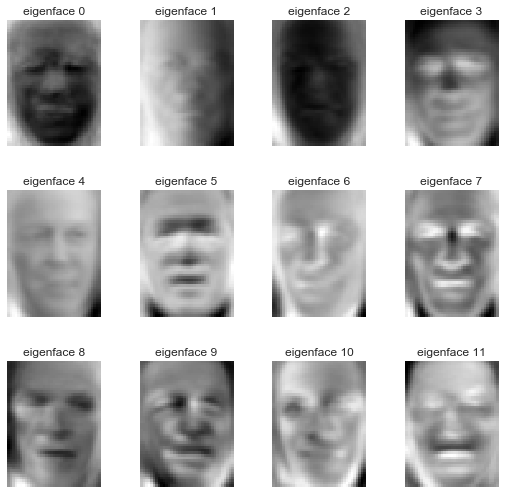

In [35]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model2.predict_classes(X_test_pca)
y_pred_NN2 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## NN after pruning 50%

In [36]:
# MAB_NN(50%REMOVED) MODEL1 125
model3 = Sequential()
model3.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(7, activation="softmax"))
model3.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/UCB1/spam124.hdf5')
model3.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.77      0.85      0.81        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.88      0.94      0.91       146
Gerhard Schroeder       0.83      0.76      0.79        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.93      0.75      0.83        36

      avg / total       0.85      0.84      0.84       322

[[  8   2   2   1   0   0   0]
 [  1  51   2   4   0   2   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 137   0   1   1]
 [  0   2   0   4  19   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   4   2   0  27]]


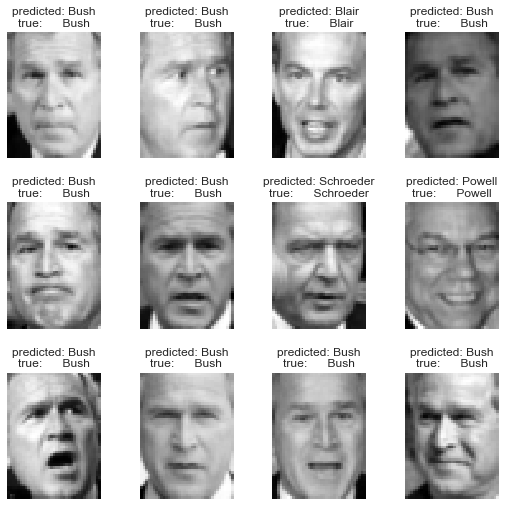

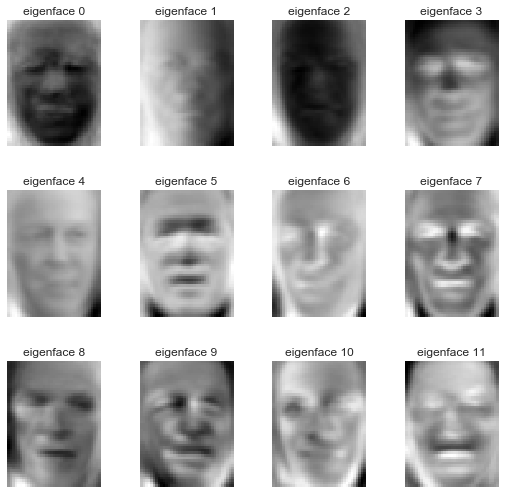

In [37]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model2.predict_classes(X_test_pca)
y_pred_NN3 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## UCB1 prune over 80%

In [38]:
model4 = Sequential()
model4.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(7, activation="softmax"))
model4.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/UCB1/spam150.hdf5')
model4.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.055s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.83      0.82      0.82        60
  Donald Rumsfeld       0.62      0.85      0.72        27
    George W Bush       0.84      0.94      0.88       146
Gerhard Schroeder       0.83      0.76      0.79        25
      Hugo Chavez       0.86      0.40      0.55        15
       Tony Blair       1.00      0.64      0.78        36

      avg / total       0.83      0.82      0.81       322

[[  7   2   2   2   0   0   0]
 [  1  49   5   4   0   1   0]
 [  1   1  23   2   0   0   0]
 [  0   3   5 137   1   0   0]
 [  0   1   0   5  19   0   0]
 [  0   1   0   6   2   6   0]
 [  0   2   2   8   1   0  23]]


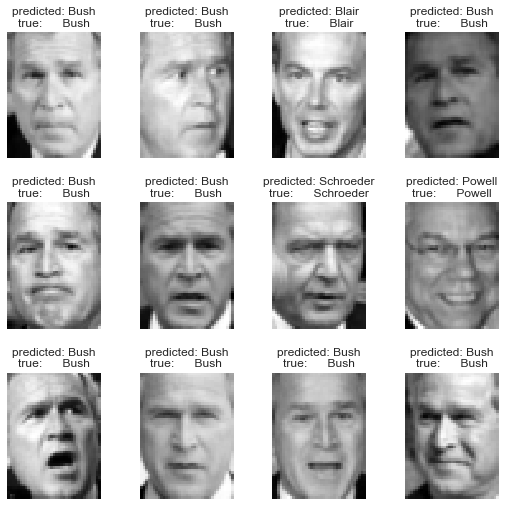

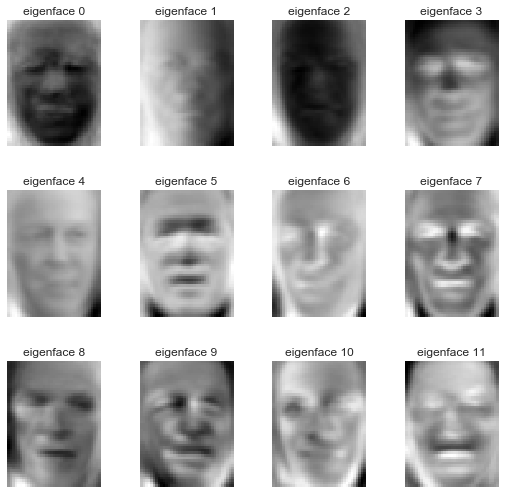

In [39]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model4.predict_classes(X_test_pca)
y_pred_NN4 = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Epsilon Greedy

In [40]:
# MAB_NN(50%REMOVED) MODEL1 125
model_EG = Sequential()
model_EG.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_EG.add(Dropout(0.5))
model_EG.add(Dense(7, activation="softmax"))
model_EG.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/EpsilonGreedy/spam20.hdf5')
model_EG.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.059s
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.74      0.85      0.79        27
    George W Bush       0.90      0.94      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.86      0.86       322

[[  8   2   2   1   0   0   0]
 [  1  52   2   4   0   1   0]
 [  0   2  23   2   0   0   0]
 [  0   5   3 137   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


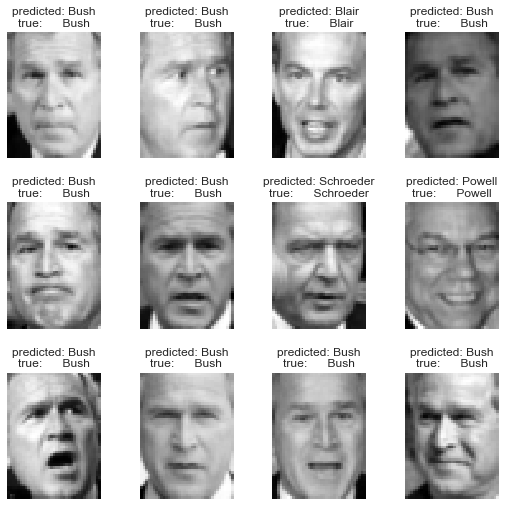

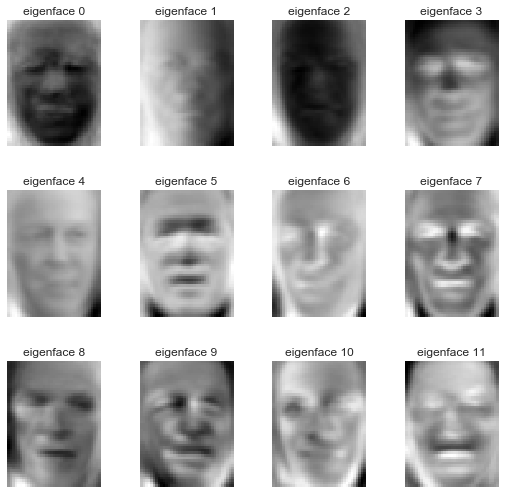

In [41]:
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_EG.predict_classes(X_test_pca)
y_pred_EG = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Decay  Epsilon Greedy

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.057s
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.54      0.64        13
     Colin Powell       0.79      0.87      0.83        60
  Donald Rumsfeld       0.79      0.81      0.80        27
    George W Bush       0.90      0.95      0.92       146
Gerhard Schroeder       0.77      0.80      0.78        25
      Hugo Chavez       0.75      0.60      0.67        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.85      0.85       322

[[  7   2   2   2   0   0   0]
 [  2  52   1   3   0   2   0]
 [  0   2  22   3   0   0   0]
 [  0   5   2 138   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   2   4   0  27]]


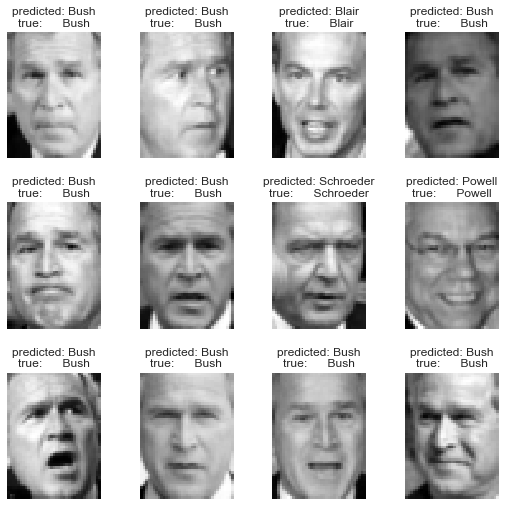

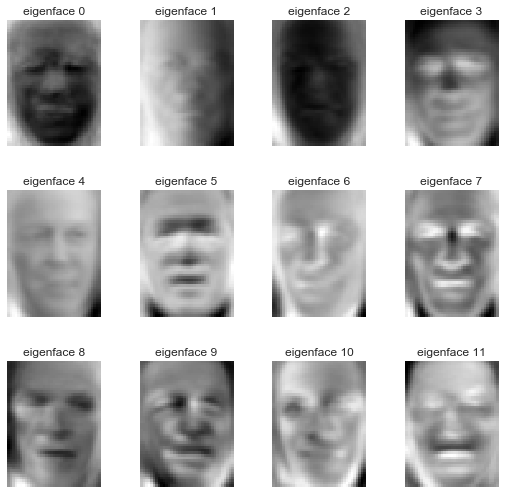

In [42]:
model_AEG = Sequential()
model_AEG.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_AEG.add(Dropout(0.5))
model_AEG.add(Dense(7, activation="softmax"))
model_AEG.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/AnnealingEpsilonGreedy/spam20.hdf5')
model_AEG.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_AEG.predict_classes(X_test_pca)
y_pred_AEG = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Softmax

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.082s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.85      0.85       322

[[  7   2   2   2   0   0   0]
 [  1  53   2   3   0   1   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 138   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


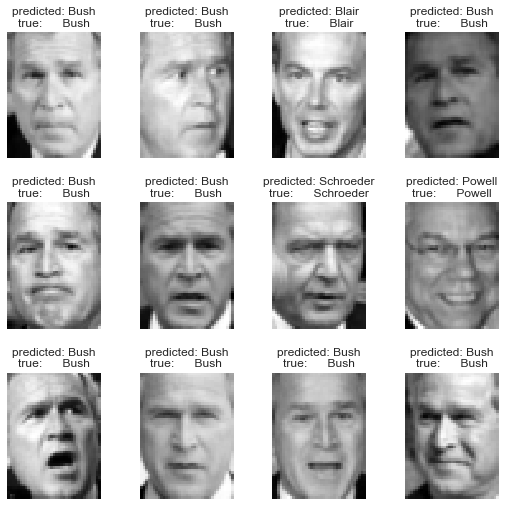

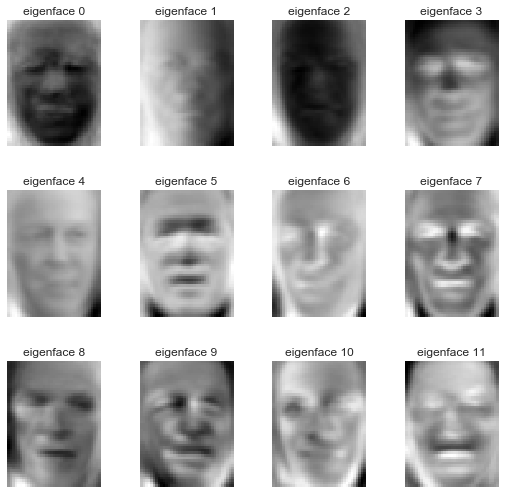

In [43]:
model_SM = Sequential()
model_SM.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_SM.add(Dropout(0.5))
model_SM.add(Dense(7, activation="softmax"))
model_SM.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/Softmax/spam20.hdf5')
model_SM.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_SM = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## Decaying Softmax

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.85      0.85       322

[[  7   2   2   2   0   0   0]
 [  1  53   2   3   0   1   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 138   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


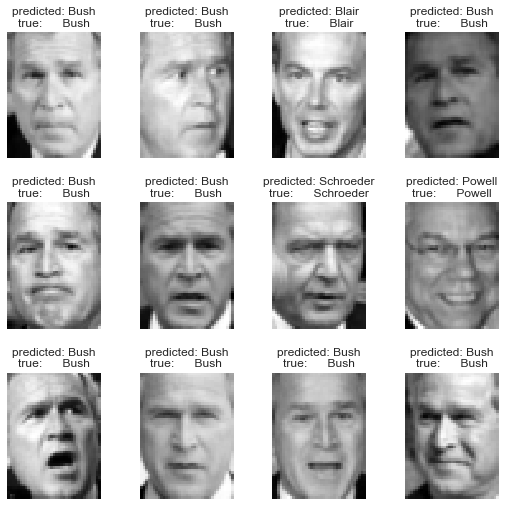

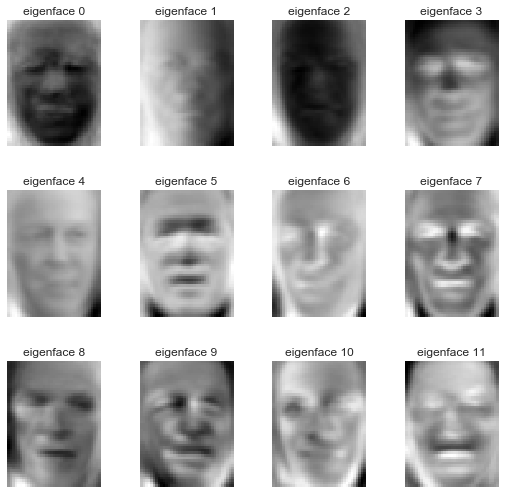

In [44]:
model_ASM = Sequential()
model_ASM.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_ASM.add(Dropout(0.5))
model_ASM.add(Dense(7, activation="softmax"))
model_ASM.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/AnnealingSoftmax/spam20.hdf5')
model_ASM.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_ASM = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## THOMPSON SAMBLING

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.85      0.85       322

[[  7   2   2   2   0   0   0]
 [  1  53   2   3   0   1   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 138   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


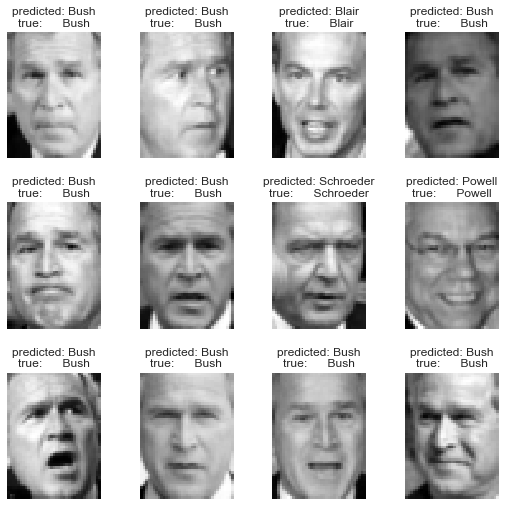

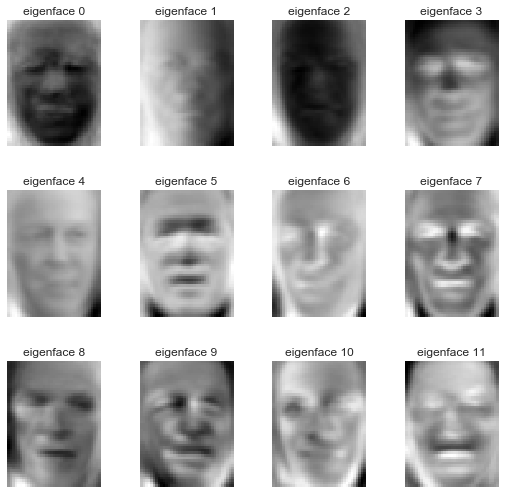

In [45]:
model_TS = Sequential()
model_TS.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_TS.add(Dropout(0.5))
model_TS.add(Dense(7, activation="softmax"))
model_TS.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/thompson_sampling/spam20.hdf5')
model_TS.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_TS = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## HEDGE

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.85      0.85       322

[[  7   2   2   2   0   0   0]
 [  1  53   2   3   0   1   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 138   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


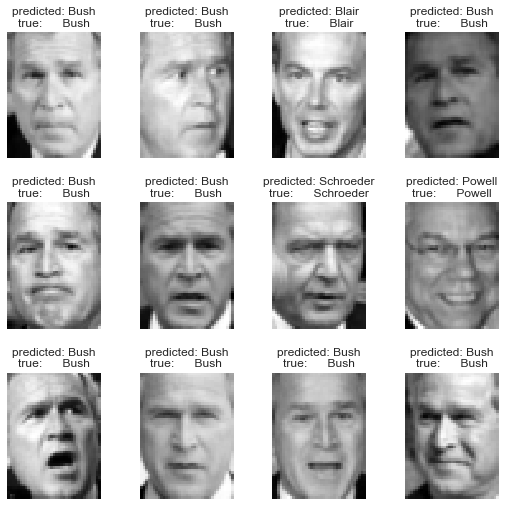

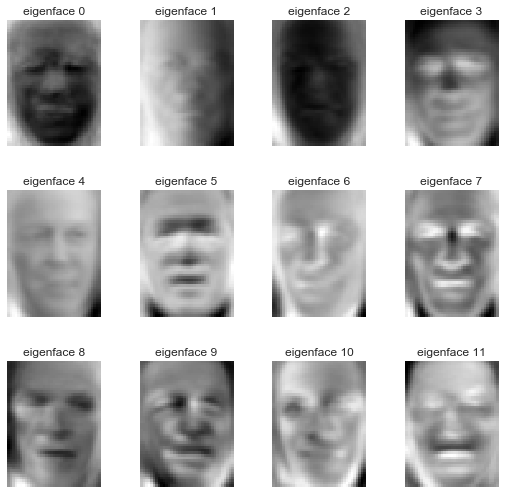

In [46]:
model_HG = Sequential()
model_HG.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_HG.add(Dropout(0.5))
model_HG.add(Dense(7, activation="softmax"))
model_HG.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/Hedge/spam20.hdf5')
model_HG.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_HG = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

## EXP3

Predicting people's names on the test set
 32/322 [=>............................] - ETA: 0sdone in 0.006s
                   precision    recall  f1-score   support

     Ariel Sharon       0.88      0.54      0.67        13
     Colin Powell       0.79      0.88      0.83        60
  Donald Rumsfeld       0.75      0.78      0.76        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.80      0.80      0.80        25
      Hugo Chavez       0.82      0.60      0.69        15
       Tony Blair       0.96      0.75      0.84        36

      avg / total       0.86      0.85      0.85       322

[[  7   2   2   2   0   0   0]
 [  1  53   2   3   0   1   0]
 [  0   2  21   4   0   0   0]
 [  0   5   2 138   0   1   0]
 [  0   1   0   4  20   0   0]
 [  0   2   0   1   2   9   1]
 [  0   2   1   3   3   0  27]]


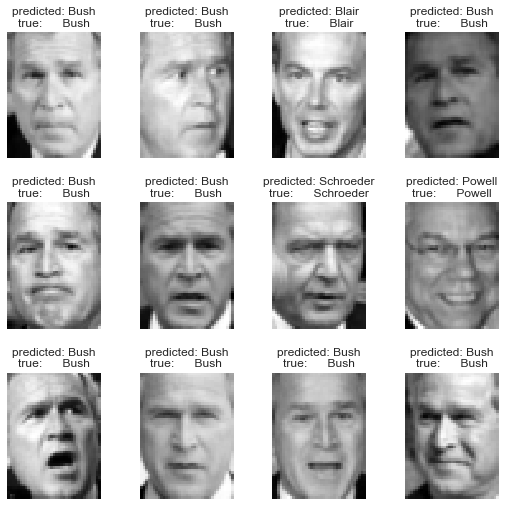

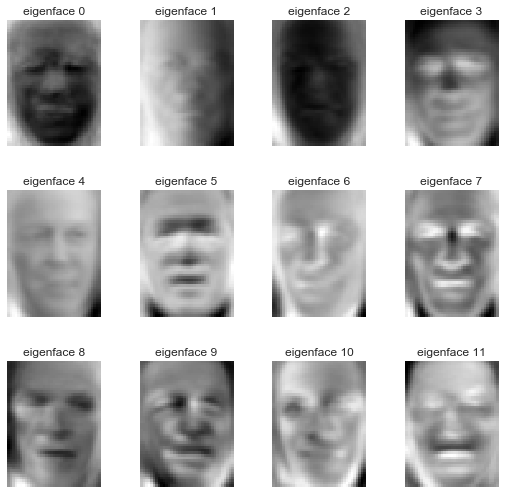

In [47]:
model_EXP = Sequential()
model_EXP.add(Dense(300,
                input_shape=(150,), 
                activation="relu"))
model_EXP.add(Dropout(0.5))
model_EXP.add(Dense(7, activation="softmax"))
model_EXP.load_weights('/Users/salemameen/Desktop/banditsbook/python_face/Exp3/spam20.hdf5')
model_EXP.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adam')
#######################################################################################################
###############################################################################
# Quantitative evaluation of the model quality on the test set
from time import time
print("Predicting people's names on the test set")
t0 = time()
y_pred = model_SM.predict_classes(X_test_pca)
y_pred_EXP = y_pred
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred, target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]
plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()

# Compare the results

## Accuracy of the models on Testing data different UCB1 pruning

In [48]:
from sklearn import metrics
y_deploy = y_test
print("The accuracy of KNN:          \t", metrics.accuracy_score(y_test, y_pred_neigh))
print("The accuracy of SVM:          \t", metrics.accuracy_score(y_test, y_pred_svm))
print("The accuracy of DT_entorpy:   \t", metrics.accuracy_score(y_test, y_pred_dt_IG))
print("The accuracy of NN:           \t", metrics.accuracy_score(y_test, y_pred_NN))
print("The accuracy of NN16.676R:    \t", metrics.accuracy_score(y_test, y_pred_NN1))
print("The accuracy of NN33.33R:     \t", metrics.accuracy_score(y_test, y_pred_NN2))
print("The accuracy of NN50R:        \t", metrics.accuracy_score(y_test, y_pred_NN3))

The accuracy of KNN:          	 0.695652173913
The accuracy of SVM:          	 0.835403726708
The accuracy of DT_entorpy:   	 0.388198757764
The accuracy of NN:           	 0.854037267081
The accuracy of NN16.676R:    	 0.854037267081
The accuracy of NN33.33R:     	 0.844720496894
The accuracy of NN50R:        	 0.844720496894


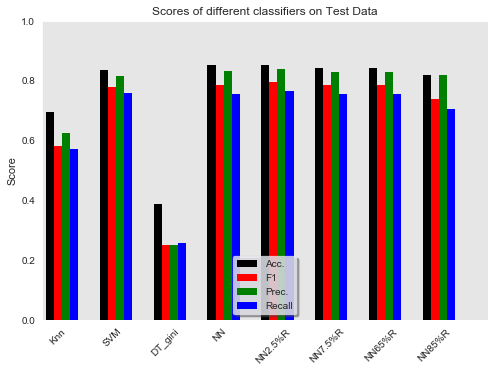

In [49]:
fig = plt.figure()
ax = fig.add_subplot(111)
accData = [metrics.accuracy_score(y_deploy, y_pred_neigh),
           metrics.accuracy_score(y_deploy, y_pred_svm), 
           metrics.accuracy_score(y_deploy, y_pred_dt_IG), 
           metrics.accuracy_score(y_deploy, y_pred_NN),
           metrics.accuracy_score(y_deploy, y_pred_NN1),
           metrics.accuracy_score(y_deploy, y_pred_NN2),
           metrics.accuracy_score(y_deploy, y_pred_NN3),
           metrics.accuracy_score(y_deploy, y_pred_NN4)]
PresionData = [metrics.precision_score(y_deploy, y_pred_neigh, average="macro"),
               metrics.precision_score(y_deploy, y_pred_svm, average="macro"),
               metrics.precision_score(y_deploy, y_pred_dt_IG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN1, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN2, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN3, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN4, average="macro")]
RecallData = [ metrics.recall_score(y_deploy, y_pred_neigh, average="macro"),
              metrics.recall_score(y_deploy, y_pred_svm, average="macro"),
              metrics.recall_score(y_deploy, y_pred_dt_IG, average="macro"),
              metrics.recall_score(y_deploy, y_pred_NN, average="macro"),
              metrics.recall_score(y_deploy, y_pred_NN1, average="macro"),
              metrics.recall_score(y_deploy, y_pred_NN2, average="macro"),
              metrics.recall_score(y_deploy, y_pred_NN3, average="macro"),
              metrics.recall_score(y_deploy, y_pred_NN4, average="macro")]
F1Data = [metrics.f1_score(y_deploy, y_pred_neigh, average="macro"),
          metrics.f1_score(y_deploy, y_pred_svm, average="macro"),
          metrics.f1_score(y_deploy, y_pred_dt_IG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN1, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN2, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN3, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN4, average="macro")]
N = len(accData)
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.15                     # the width of the bars
## the bars
rects1 = ax.bar(ind, accData, width,
                color='black',
                #yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))
rects2 = ax.bar(ind+width, F1Data, width,
                    color='red',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))
rects3 = ax.bar(ind+width+width, PresionData, width,
                    color='green',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='blue'))
rects4 = ax.bar(ind+width+width+width, RecallData, width,
                    color='blue',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='green'))
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_title('Scores of different classifiers on Test Data')
xTickMarks = ['Knn', 'SVM', 'DT_gini' , 'NN', 'NN2.5%R' , 'NN7.5%R' , 'NN65%R' , 'NN85%R']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=10)



## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Acc.', 'F1' , 'Prec.' , 'Recall') , loc=8, fancybox=True, 
          frameon=True, shadow=True)
ax.set_facecolor('0.9')

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.spines['top'].set_linewidth(0.9)
ax.spines['right'].set_linewidth(0.9)
ax.spines['bottom'].set_linewidth(0.9)
ax.spines['left'].set_linewidth(0.9)
ax.grid(False)
plt.show()

In [50]:
import pandas as pd
from math import pi
from bokeh.charts import Bar, Area, defaults
from bokeh.layouts import row
from bokeh.charts.attributes import cat, color
from bokeh.charts.operations import blend
#from bokeh.charts.utils import df_from_json
from bokeh.plotting import figure, output_notebook, show
############################################################################################################
TOOLS = 'box_zoom,box_select,crosshair,resize,reset,lasso_select,pan,save,poly_select,tap,wheel_zoom,undo'
#defaults.width = 1000
#defaults.height = 800
output_notebook()
df1 = pd.DataFrame({'Matric': xTickMarks,
                    'Accuracy':accData, 
                   'Precision': PresionData, 
                   'Recall': RecallData, 
                    'F1 Score': F1Data})
############################################################################################################
bar = Bar(df1,
          values=blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
          label=cat(columns='Matric', sort=False),
          stack=cat(columns='Score', sort=False),
          color=color(columns='Score', palette=['SaddleBrown', 'Silver', 'Goldenrod', 'Grey'],
                      sort=False),
          legend='bottom_center', xlabel="List of Models", ylabel="The Scores",
          title="Scores of different Models", 
          tooltips=[('Score', '@Score'), ('Model', '@Matric')],
          tools=TOOLS, plot_width=900, plot_height=800)
bar.title.align = "center"
bar.xaxis.major_label_orientation = pi/2
###############################################################################################################
p = Bar(df1, label='Matric', 
        values = blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
        group=cat(columns='Score', sort=False),
        title="Scores of different Models", legend='bottom_center',
       tools=TOOLS, plot_width=900, plot_height=600,
       xlabel='List of Models', ylabel='The Scores')
p.title.align = "center"
#p.yaxis.major_label_orientation = "vertical"
p.xaxis.major_label_orientation = pi/2
#########################################################################################################
data = dict(
    Acc = accData,
    Pre = PresionData,
    Rec = RecallData,
    F1 = F1Data,
)
area1 = Area(data, title="The trend of score over Models", legend="bottom_center",
             xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area1.title.align = "center"
area2 = Area(data, title="The trend of score over Models", legend="bottom_center",
             stack=True, xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area2.title.align = "center"
#########################################################################################################
show(bar)
show(p)
#show(area1)
#show(area2)
show(row(area1, area2))

Loading BokehJS ...

## Compare All the results

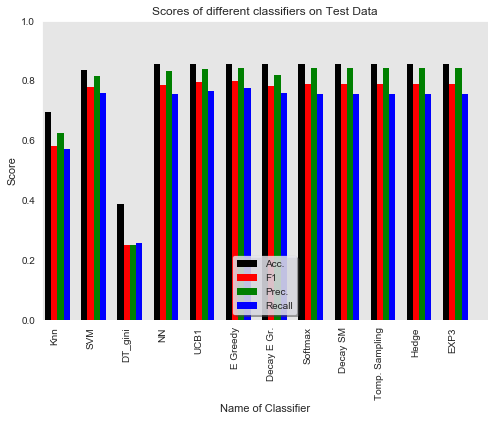

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)
accData = [metrics.accuracy_score(y_deploy, y_pred_neigh),
           metrics.accuracy_score(y_deploy, y_pred_svm), 
           metrics.accuracy_score(y_deploy, y_pred_dt_IG), 
           metrics.accuracy_score(y_deploy, y_pred_NN),        
           metrics.accuracy_score(y_deploy, y_pred_NN1),
           metrics.accuracy_score(y_deploy, y_pred_EG),
           metrics.accuracy_score(y_deploy, y_pred_AEG),
           metrics.accuracy_score(y_deploy, y_pred_SM),
           metrics.accuracy_score(y_deploy, y_pred_ASM),
           metrics.accuracy_score(y_deploy, y_pred_TS),
           metrics.accuracy_score(y_deploy, y_pred_HG),
           metrics.accuracy_score(y_deploy, y_pred_EXP)]
          
PresionData = [metrics.precision_score(y_deploy, y_pred_neigh, average="macro"),
               metrics.precision_score(y_deploy, y_pred_svm, average="macro"),
               metrics.precision_score(y_deploy, y_pred_dt_IG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN1, average="macro"),
               metrics.precision_score(y_deploy, y_pred_EG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_AEG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_SM, average="macro"),
               metrics.precision_score(y_deploy, y_pred_ASM, average="macro"),
               metrics.precision_score(y_deploy, y_pred_TS, average="macro"),
               metrics.precision_score(y_deploy, y_pred_HG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_EXP, average="macro")]

RecallData = [ metrics.recall_score(y_deploy, y_pred_neigh, average="macro"),
              metrics.recall_score(y_deploy, y_pred_svm, average="macro"),
              metrics.recall_score(y_deploy, y_pred_dt_IG, average="macro"),   
              metrics.recall_score(y_deploy, y_pred_NN, average="macro"),
              metrics.recall_score(y_deploy, y_pred_NN1, average="macro"),
              metrics.recall_score(y_deploy, y_pred_EG, average="macro"),
              metrics.recall_score(y_deploy, y_pred_AEG, average="macro"),
              metrics.recall_score(y_deploy, y_pred_SM, average="macro"),
              metrics.recall_score(y_deploy, y_pred_ASM, average="macro"),
              metrics.recall_score(y_deploy, y_pred_TS, average="macro"),
              metrics.recall_score(y_deploy, y_pred_HG, average="macro"),
              metrics.recall_score(y_deploy, y_pred_EXP, average="macro")]
F1Data = [metrics.f1_score(y_deploy, y_pred_neigh, average="macro"),
          metrics.f1_score(y_deploy, y_pred_svm, average="macro"),
          metrics.f1_score(y_deploy, y_pred_dt_IG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN, average="macro"),                             
          metrics.f1_score(y_deploy, y_pred_NN1, average="macro"),
          metrics.f1_score(y_deploy, y_pred_EG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_AEG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_SM, average="macro"),
          metrics.f1_score(y_deploy, y_pred_ASM, average="macro"),
          metrics.f1_score(y_deploy, y_pred_TS, average="macro"),
          metrics.f1_score(y_deploy, y_pred_HG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_EXP, average="macro")]         



N = len(accData)
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.17                     # the width of the bars
## the bars
rects1 = ax.bar(ind, accData, width,
                color='black',
                #yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))
rects2 = ax.bar(ind+width, F1Data, width,
                    color='red',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))
rects3 = ax.bar(ind+width+width, PresionData, width,
                    color='green',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='blue'))
rects4 = ax.bar(ind+width+width+width, RecallData, width,
                    color='blue',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='green'))
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_xlabel('Name of Classifier')
ax.set_title('Scores of different classifiers on Test Data')
xTickMarks = ['Knn', 'SVM', 'DT_gini' ,
              'NN', 'UCB1' , 'E Greedy' , 'Decay E Gr.' , 'Softmax', 'Decay SM',
               'Tomp. Sampling', 'Hedge', 'EXP3']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Acc.', 'F1' , 'Prec.' , 'Recall') , loc=8, fancybox=True, 
          frameon=True, shadow=True)
ax.set_facecolor('0.9')

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.spines['top'].set_linewidth(0.9)
ax.spines['right'].set_linewidth(0.9)
ax.spines['bottom'].set_linewidth(0.9)
ax.spines['left'].set_linewidth(0.9)
ax.grid(False)
plt.show()

In [52]:

df1 = pd.DataFrame({'Matric': xTickMarks,
                    'Accuracy':accData, 
                   'Precision': PresionData, 
                   'Recall': RecallData, 
                    'F1 Score': F1Data})
############################################################################################################
bar = Bar(df1,
          values=blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
          label=cat(columns='Matric', sort=False),
          stack=cat(columns='Score', sort=False),
          color=color(columns='Score', palette=['SaddleBrown', 'Silver', 'Goldenrod', 'Grey'],
                      sort=False),
          legend='bottom_center', xlabel="List of Models", ylabel="The Scores",
          title="Scores of different Models", 
          tooltips=[('Score', '@Score'), ('Model', '@Matric')],
          tools=TOOLS, plot_width=900, plot_height=800)
bar.title.align = "center"
bar.xaxis.major_label_orientation = pi/2
###############################################################################################################
p = Bar(df1, label='Matric', 
        values = blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
        group=cat(columns='Score', sort=False),
        title="Scores of different Models", legend='bottom_center',
       tools=TOOLS, plot_width=900, plot_height=600,
       xlabel='List of Models', ylabel='The Scores')
p.title.align = "center"
#p.yaxis.major_label_orientation = "vertical"
p.xaxis.major_label_orientation = pi/2
#########################################################################################################
data = dict(
    Acc = accData,
    Pre = PresionData,
    Rec = RecallData,
    F1 = F1Data,
)
area1 = Area(data, title="The trend of score over Models", legend="bottom_center",
             xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area1.title.align = "center"
area2 = Area(data, title="The trend of score over Models", legend="bottom_center",
             stack=True, xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area2.title.align = "center"
#########################################################################################################
show(bar)
show(p)
#show(area1)
#show(area2)
show(row(area1, area2))

In [53]:
df1.to_csv('face.csv')

## UCB1

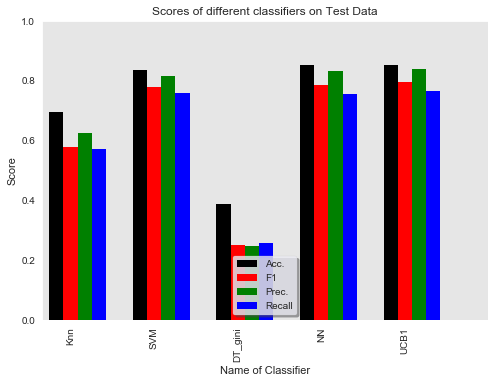

In [54]:
fig = plt.figure()
ax = fig.add_subplot(111)
accData = [metrics.accuracy_score(y_deploy, y_pred_neigh),
           metrics.accuracy_score(y_deploy, y_pred_svm), 
           metrics.accuracy_score(y_deploy, y_pred_dt_IG), 
           metrics.accuracy_score(y_deploy, y_pred_NN),        
           metrics.accuracy_score(y_deploy, y_pred_NN1)]
          
PresionData = [metrics.precision_score(y_deploy, y_pred_neigh, average="macro"),
               metrics.precision_score(y_deploy, y_pred_svm, average="macro"),
               metrics.precision_score(y_deploy, y_pred_dt_IG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN1, average="macro")]

RecallData = [ metrics.recall_score(y_deploy, y_pred_neigh, average="macro"),
              metrics.recall_score(y_deploy, y_pred_svm, average="macro"),
              metrics.recall_score(y_deploy, y_pred_dt_IG, average="macro"),   
              metrics.recall_score(y_deploy, y_pred_NN, average="macro"),
              metrics.recall_score(y_deploy, y_pred_NN1, average="macro")]
F1Data = [metrics.f1_score(y_deploy, y_pred_neigh, average="macro"),
          metrics.f1_score(y_deploy, y_pred_svm, average="macro"),
          metrics.f1_score(y_deploy, y_pred_dt_IG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN, average="macro"),                             
          metrics.f1_score(y_deploy, y_pred_NN1, average="macro")]         



N = len(accData)
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.17                     # the width of the bars
## the bars
rects1 = ax.bar(ind, accData, width,
                color='black',
                #yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))
rects2 = ax.bar(ind+width, F1Data, width,
                    color='red',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))
rects3 = ax.bar(ind+width+width, PresionData, width,
                    color='green',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='blue'))
rects4 = ax.bar(ind+width+width+width, RecallData, width,
                    color='blue',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='green'))
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_xlabel('Name of Classifier')
ax.set_title('Scores of different classifiers on Test Data')
xTickMarks = ['Knn', 'SVM', 'DT_gini' ,
              'NN', 'UCB1']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Acc.', 'F1' , 'Prec.' , 'Recall') , loc=8, fancybox=True, 
          frameon=True, shadow=True)
ax.set_facecolor('0.9')

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.spines['top'].set_linewidth(0.9)
ax.spines['right'].set_linewidth(0.9)
ax.spines['bottom'].set_linewidth(0.9)
ax.spines['left'].set_linewidth(0.9)
ax.grid(False)
plt.show()

In [55]:

df1 = pd.DataFrame({'Matric': xTickMarks,
                    'Accuracy':accData, 
                   'Precision': PresionData, 
                   'Recall': RecallData, 
                    'F1 Score': F1Data})
############################################################################################################
bar = Bar(df1,
          values=blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
          label=cat(columns='Matric', sort=False),
          stack=cat(columns='Score', sort=False),
          color=color(columns='Score', palette=['SaddleBrown', 'Silver', 'Goldenrod', 'Grey'],
                      sort=False),
          legend='bottom_center', xlabel="List of Models", ylabel="The Scores",
          title="Scores of different Models", 
          tooltips=[('Score', '@Score'), ('Model', '@Matric')],
          tools=TOOLS, plot_width=900, plot_height=800)
bar.title.align = "center"
bar.xaxis.major_label_orientation = pi/2
###############################################################################################################
p = Bar(df1, label='Matric', 
        values = blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
        group=cat(columns='Score', sort=False),
        title="Scores of different Models", legend='bottom_center',
       tools=TOOLS, plot_width=900, plot_height=600,
       xlabel='List of Models', ylabel='The Scores')
p.title.align = "center"
#p.yaxis.major_label_orientation = "vertical"
p.xaxis.major_label_orientation = pi/2
#########################################################################################################
data = dict(
    Acc = accData,
    Pre = PresionData,
    Rec = RecallData,
    F1 = F1Data,
)
area1 = Area(data, title="The trend of score over Models", legend="bottom_center",
             xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area1.title.align = "center"
area2 = Area(data, title="The trend of score over Models", legend="bottom_center",
             stack=True, xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area2.title.align = "center"
#########################################################################################################
show(bar)
show(p)
#show(area1)
#show(area2)
show(row(area1, area2))

# Greedy and Softmax

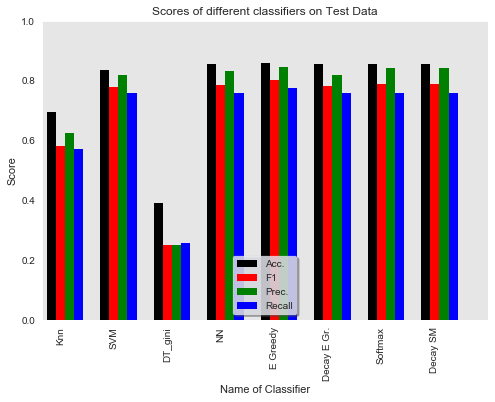

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
accData = [metrics.accuracy_score(y_deploy, y_pred_neigh),
           metrics.accuracy_score(y_deploy, y_pred_svm), 
           metrics.accuracy_score(y_deploy, y_pred_dt_IG), 
           metrics.accuracy_score(y_deploy, y_pred_NN),        
           metrics.accuracy_score(y_deploy, y_pred_EG),
           metrics.accuracy_score(y_deploy, y_pred_AEG),
           metrics.accuracy_score(y_deploy, y_pred_SM),
           metrics.accuracy_score(y_deploy, y_pred_ASM)]
          
PresionData = [metrics.precision_score(y_deploy, y_pred_neigh, average="macro"),
               metrics.precision_score(y_deploy, y_pred_svm, average="macro"),
               metrics.precision_score(y_deploy, y_pred_dt_IG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN, average="macro"),
               metrics.precision_score(y_deploy, y_pred_EG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_AEG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_SM, average="macro"),
               metrics.precision_score(y_deploy, y_pred_ASM, average="macro")]

RecallData = [ metrics.recall_score(y_deploy, y_pred_neigh, average="macro"),
              metrics.recall_score(y_deploy, y_pred_svm, average="macro"),
              metrics.recall_score(y_deploy, y_pred_dt_IG, average="macro"),   
              metrics.recall_score(y_deploy, y_pred_NN, average="macro"),
              metrics.recall_score(y_deploy, y_pred_EG, average="macro"),
              metrics.recall_score(y_deploy, y_pred_AEG, average="macro"),
              metrics.recall_score(y_deploy, y_pred_SM, average="macro"),
              metrics.recall_score(y_deploy, y_pred_ASM, average="macro")]

F1Data = [metrics.f1_score(y_deploy, y_pred_neigh, average="macro"),
          metrics.f1_score(y_deploy, y_pred_svm, average="macro"),
          metrics.f1_score(y_deploy, y_pred_dt_IG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN, average="macro"),                             
          metrics.f1_score(y_deploy, y_pred_EG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_AEG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_SM, average="macro"),
          metrics.f1_score(y_deploy, y_pred_ASM, average="macro")]         



N = len(accData)
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.17                     # the width of the bars
## the bars
rects1 = ax.bar(ind, accData, width,
                color='black',
                #yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))
rects2 = ax.bar(ind+width, F1Data, width,
                    color='red',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))
rects3 = ax.bar(ind+width+width, PresionData, width,
                    color='green',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='blue'))
rects4 = ax.bar(ind+width+width+width, RecallData, width,
                    color='blue',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='green'))
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_xlabel('Name of Classifier')
ax.set_title('Scores of different classifiers on Test Data')
xTickMarks = ['Knn', 'SVM', 'DT_gini' ,
              'NN',  'E Greedy' , 'Decay E Gr.' , 'Softmax', 'Decay SM']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Acc.', 'F1' , 'Prec.' , 'Recall') , loc=8, fancybox=True, 
          frameon=True, shadow=True)
ax.set_facecolor('0.9')

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.spines['top'].set_linewidth(0.9)
ax.spines['right'].set_linewidth(0.9)
ax.spines['bottom'].set_linewidth(0.9)
ax.spines['left'].set_linewidth(0.9)
ax.grid(False)
plt.show()

In [57]:

df1 = pd.DataFrame({'Matric': xTickMarks,
                    'Accuracy':accData, 
                   'Precision': PresionData, 
                   'Recall': RecallData, 
                    'F1 Score': F1Data})
############################################################################################################
bar = Bar(df1,
          values=blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
          label=cat(columns='Matric', sort=False),
          stack=cat(columns='Score', sort=False),
          color=color(columns='Score', palette=['SaddleBrown', 'Silver', 'Goldenrod', 'Grey'],
                      sort=False),
          legend='bottom_center', xlabel="List of Models", ylabel="The Scores",
          title="Scores of different Models", 
          tooltips=[('Score', '@Score'), ('Model', '@Matric')],
          tools=TOOLS, plot_width=900, plot_height=800)
bar.title.align = "center"
bar.xaxis.major_label_orientation = pi/2
###############################################################################################################
p = Bar(df1, label='Matric', 
        values = blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
        group=cat(columns='Score', sort=False),
        title="Scores of different Models", legend='bottom_center',
       tools=TOOLS, plot_width=900, plot_height=600,
       xlabel='List of Models', ylabel='The Scores')
p.title.align = "center"
#p.yaxis.major_label_orientation = "vertical"
p.xaxis.major_label_orientation = pi/2
#########################################################################################################
data = dict(
    Acc = accData,
    Pre = PresionData,
    Rec = RecallData,
    F1 = F1Data,
)
area1 = Area(data, title="The trend of score over Models", legend="bottom_center",
             xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area1.title.align = "center"
area2 = Area(data, title="The trend of score over Models", legend="bottom_center",
             stack=True, xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area2.title.align = "center"
#########################################################################################################
show(bar)
show(p)
#show(area1)
#show(area2)
show(row(area1, area2))

## THompson Sampling

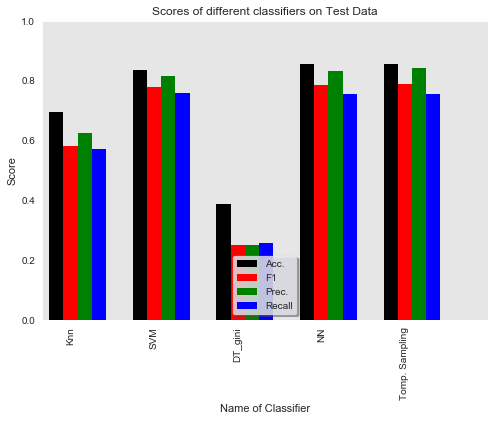

In [58]:
fig = plt.figure()
ax = fig.add_subplot(111)
accData = [metrics.accuracy_score(y_deploy, y_pred_neigh),
           metrics.accuracy_score(y_deploy, y_pred_svm), 
           metrics.accuracy_score(y_deploy, y_pred_dt_IG), 
           metrics.accuracy_score(y_deploy, y_pred_NN),        
           metrics.accuracy_score(y_deploy, y_pred_TS)]
          
PresionData = [metrics.precision_score(y_deploy, y_pred_neigh, average="macro"),
               metrics.precision_score(y_deploy, y_pred_svm, average="macro"),
               metrics.precision_score(y_deploy, y_pred_dt_IG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN, average="macro"),
               metrics.precision_score(y_deploy, y_pred_TS, average="macro")]

RecallData = [ metrics.recall_score(y_deploy, y_pred_neigh, average="macro"),
              metrics.recall_score(y_deploy, y_pred_svm, average="macro"),
              metrics.recall_score(y_deploy, y_pred_dt_IG, average="macro"),   
              metrics.recall_score(y_deploy, y_pred_NN, average="macro"),
              metrics.recall_score(y_deploy, y_pred_TS, average="macro")]

F1Data = [metrics.f1_score(y_deploy, y_pred_neigh, average="macro"),
          metrics.f1_score(y_deploy, y_pred_svm, average="macro"),
          metrics.f1_score(y_deploy, y_pred_dt_IG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN, average="macro"),                             
          metrics.f1_score(y_deploy, y_pred_TS, average="macro")]         



N = len(accData)
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.17                     # the width of the bars
## the bars
rects1 = ax.bar(ind, accData, width,
                color='black',
                #yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))
rects2 = ax.bar(ind+width, F1Data, width,
                    color='red',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))
rects3 = ax.bar(ind+width+width, PresionData, width,
                    color='green',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='blue'))
rects4 = ax.bar(ind+width+width+width, RecallData, width,
                    color='blue',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='green'))
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_xlabel('Name of Classifier')
ax.set_title('Scores of different classifiers on Test Data')
xTickMarks = ['Knn', 'SVM', 'DT_gini' ,
              'NN', 'Tomp. Sampling']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Acc.', 'F1' , 'Prec.' , 'Recall') , loc=8, fancybox=True, 
          frameon=True, shadow=True)
ax.set_facecolor('0.9')

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.spines['top'].set_linewidth(0.9)
ax.spines['right'].set_linewidth(0.9)
ax.spines['bottom'].set_linewidth(0.9)
ax.spines['left'].set_linewidth(0.9)
ax.grid(False)
plt.show()

In [59]:

df1 = pd.DataFrame({'Matric': xTickMarks,
                    'Accuracy':accData, 
                   'Precision': PresionData, 
                   'Recall': RecallData, 
                    'F1 Score': F1Data})
############################################################################################################
bar = Bar(df1,
          values=blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
          label=cat(columns='Matric', sort=False),
          stack=cat(columns='Score', sort=False),
          color=color(columns='Score', palette=['SaddleBrown', 'Silver', 'Goldenrod', 'Grey'],
                      sort=False),
          legend='bottom_center', xlabel="List of Models", ylabel="The Scores",
          title="Scores of different Models", 
          tooltips=[('Score', '@Score'), ('Model', '@Matric')],
          tools=TOOLS, plot_width=900, plot_height=800)
bar.title.align = "center"
bar.xaxis.major_label_orientation = pi/2
###############################################################################################################
p = Bar(df1, label='Matric', 
        values = blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
        group=cat(columns='Score', sort=False),
        title="Scores of different Models", legend='bottom_center',
       tools=TOOLS, plot_width=900, plot_height=600,
       xlabel='List of Models', ylabel='The Scores')
p.title.align = "center"
#p.yaxis.major_label_orientation = "vertical"
p.xaxis.major_label_orientation = pi/2
#########################################################################################################
data = dict(
    Acc = accData,
    Pre = PresionData,
    Rec = RecallData,
    F1 = F1Data,
)
area1 = Area(data, title="The trend of score over Models", legend="bottom_center",
             xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area1.title.align = "center"
area2 = Area(data, title="The trend of score over Models", legend="bottom_center",
             stack=True, xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area2.title.align = "center"
#########################################################################################################
show(bar)
show(p)
#show(area1)
#show(area2)
show(row(area1, area2))

## Hedge and EXP3

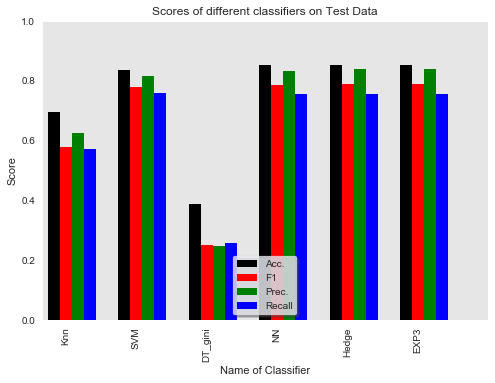

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)
accData = [metrics.accuracy_score(y_deploy, y_pred_neigh),
           metrics.accuracy_score(y_deploy, y_pred_svm), 
           metrics.accuracy_score(y_deploy, y_pred_dt_IG), 
           metrics.accuracy_score(y_deploy, y_pred_NN),        
           metrics.accuracy_score(y_deploy, y_pred_HG),
           metrics.accuracy_score(y_deploy, y_pred_EXP)]
          
PresionData = [metrics.precision_score(y_deploy, y_pred_neigh, average="macro"),
               metrics.precision_score(y_deploy, y_pred_svm, average="macro"),
               metrics.precision_score(y_deploy, y_pred_dt_IG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_NN, average="macro"),
               metrics.precision_score(y_deploy, y_pred_HG, average="macro"),
               metrics.precision_score(y_deploy, y_pred_EXP, average="macro")]

RecallData = [ metrics.recall_score(y_deploy, y_pred_neigh, average="macro"),
              metrics.recall_score(y_deploy, y_pred_svm, average="macro"),
              metrics.recall_score(y_deploy, y_pred_dt_IG, average="macro"),   
              metrics.recall_score(y_deploy, y_pred_NN, average="macro"),
              metrics.recall_score(y_deploy, y_pred_HG, average="macro"),
              metrics.recall_score(y_deploy, y_pred_EXP, average="macro")]

F1Data = [metrics.f1_score(y_deploy, y_pred_neigh, average="macro"),
          metrics.f1_score(y_deploy, y_pred_svm, average="macro"),
          metrics.f1_score(y_deploy, y_pred_dt_IG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_NN, average="macro"),                             
          metrics.f1_score(y_deploy, y_pred_HG, average="macro"),
          metrics.f1_score(y_deploy, y_pred_EXP, average="macro")]         



N = len(accData)
## necessary variables
ind = np.arange(N)                # the x locations for the groups
width = 0.17                     # the width of the bars
## the bars
rects1 = ax.bar(ind, accData, width,
                color='black',
                #yerr=menStd,
                error_kw=dict(elinewidth=2,ecolor='red'))
rects2 = ax.bar(ind+width, F1Data, width,
                    color='red',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='black'))
rects3 = ax.bar(ind+width+width, PresionData, width,
                    color='green',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='blue'))
rects4 = ax.bar(ind+width+width+width, RecallData, width,
                    color='blue',
                    #yerr=womenStd,
                    error_kw=dict(elinewidth=2,ecolor='green'))
# axes and labels
ax.set_xlim(-width,len(ind)+width)
ax.set_ylim(0,1)
ax.set_ylabel('Score')
ax.set_xlabel('Name of Classifier')
ax.set_title('Scores of different classifiers on Test Data')
xTickMarks = ['Knn', 'SVM', 'DT_gini' ,
              'NN','Hedge', 'EXP3']
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=90, fontsize=10)
## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0]), ('Acc.', 'F1' , 'Prec.' , 'Recall') , loc=8, fancybox=True, 
          frameon=True, shadow=True)
ax.set_facecolor('0.9')

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

ax.spines['top'].set_linewidth(0.9)
ax.spines['right'].set_linewidth(0.9)
ax.spines['bottom'].set_linewidth(0.9)
ax.spines['left'].set_linewidth(0.9)
ax.grid(False)
plt.show()

In [61]:

df1 = pd.DataFrame({'Matric': xTickMarks,
                    'Accuracy':accData, 
                   'Precision': PresionData, 
                   'Recall': RecallData, 
                    'F1 Score': F1Data})
############################################################################################################
bar = Bar(df1,
          values=blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
          label=cat(columns='Matric', sort=False),
          stack=cat(columns='Score', sort=False),
          color=color(columns='Score', palette=['SaddleBrown', 'Silver', 'Goldenrod', 'Grey'],
                      sort=False),
          legend='bottom_center', xlabel="List of Models", ylabel="The Scores",
          title="Scores of different Models", 
          tooltips=[('Score', '@Score'), ('Model', '@Matric')],
          tools=TOOLS, plot_width=900, plot_height=800)
bar.title.align = "center"
bar.xaxis.major_label_orientation = pi/2
###############################################################################################################
p = Bar(df1, label='Matric', 
        values = blend('Accuracy', 'F1 Score', 'Precision','Recall', name='Scores', labels_name='Score'),
        group=cat(columns='Score', sort=False),
        title="Scores of different Models", legend='bottom_center',
       tools=TOOLS, plot_width=900, plot_height=600,
       xlabel='List of Models', ylabel='The Scores')
p.title.align = "center"
#p.yaxis.major_label_orientation = "vertical"
p.xaxis.major_label_orientation = pi/2
#########################################################################################################
data = dict(
    Acc = accData,
    Pre = PresionData,
    Rec = RecallData,
    F1 = F1Data,
)
area1 = Area(data, title="The trend of score over Models", legend="bottom_center",
             xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area1.title.align = "center"
area2 = Area(data, title="The trend of score over Models", legend="bottom_center",
             stack=True, xlabel='List of Models', ylabel='The Scores',
            tools=TOOLS, plot_width=450, plot_height=300)
area2.title.align = "center"
#########################################################################################################
show(bar)
show(p)
#show(area1)
#show(area2)
show(row(area1, area2))